In [1]:
# Configure matplotlib.
%matplotlib inline

In [2]:
# Import our package.
import sys, importlib
sys.path.append("/home/ubuntu/cell_counting")

from src import dataset, visualization, preprocess, metric
from src.model import model
from src.model import neural_net
from src.model.segment_counting.convnet1 import convnet1

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [ ]:
# (if changes are made) Re-import our package.
for module in (dataset, visualization, preprocess, metric, model, neural_net, convnet1):
    importlib.reload(module)

In [3]:
# Load the microbia_segments dataset.
def image_path_getter(example_metadata):
    return "/home/ubuntu/cell_counting/data/microbia_segments/raw/" + example_metadata["Segment Relative Path"]
def mask_path_getter(example_metadata):
    return "/home/ubuntu/cell_counting/data/microbia_segments/raw/" + example_metadata["Binary Segment Relative Path"]
def label_getter(example_metadata):
    return example_metadata["data"]["segment_type"]["data"]
microbia_segments = dataset.Dataset(256)
microbia_segments.load_images_masks_labels_from_json(
    "/home/ubuntu/cell_counting/data/microbia_segments/raw/enumeration_segments.json", image_path_getter,
    mask_path_getter, label_getter, (128, 128))

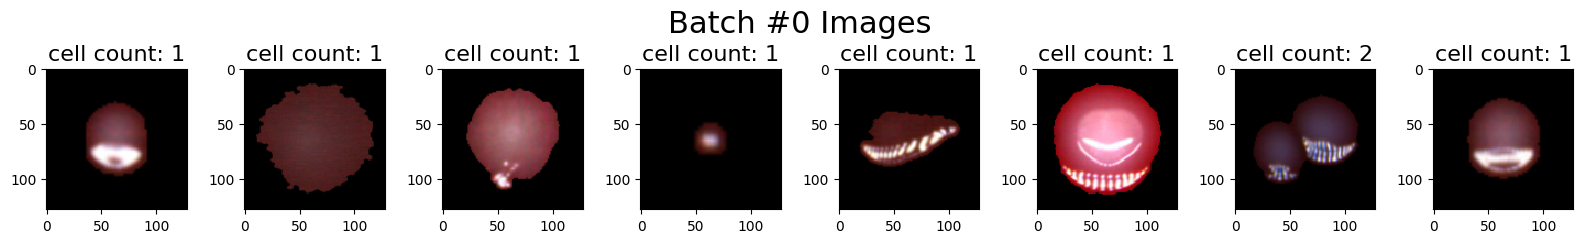

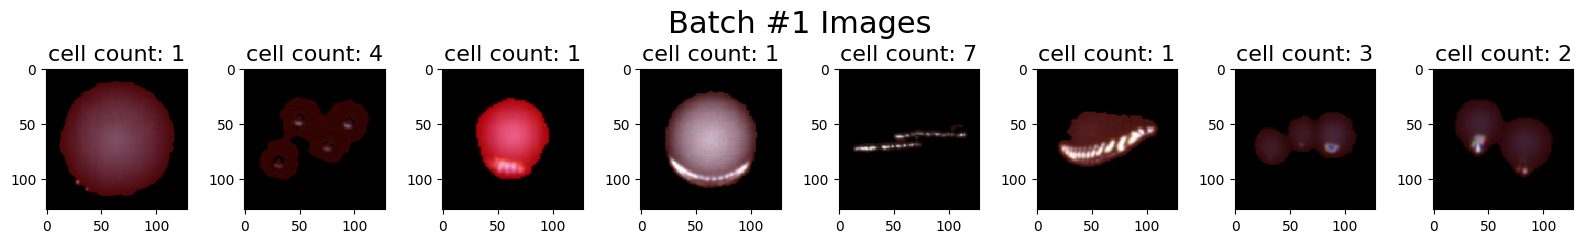

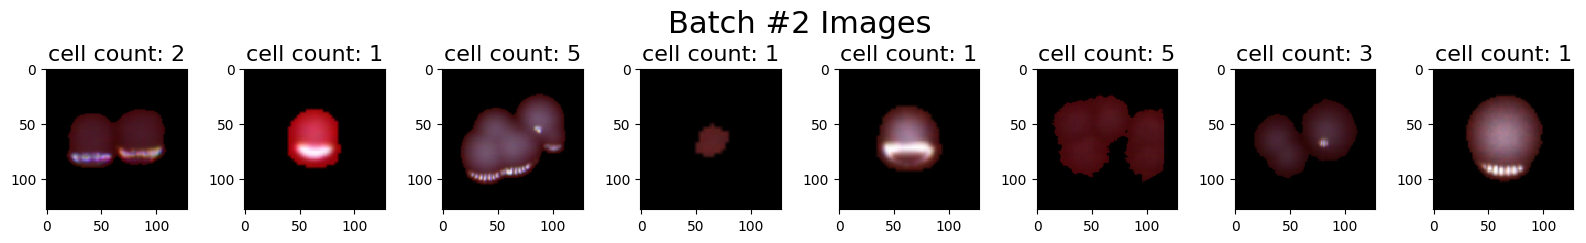

In [4]:
# Plot a few batches.
for batch in range(3):
    inputs, outputs = microbia_segments.get_batch(8)
    visualization.show_image_grid(inputs, 1, 8, 2.5, 16, "Batch #{0} Images".format(batch),
        ["cell count: {0}".format(count + 1 if count != 7 else "<OUTLIER>") for count in outputs])

In [5]:
# Make the labels one-hot.
def to_one_hot(examples):
    inputs, outputs = examples
    outputs = preprocess.one_hot_encode(outputs, 7)
    return inputs, outputs
microbia_segments.map_batch(to_one_hot)

In [6]:
# Split the dataset.
train, test = microbia_segments.split(0.1)

In [12]:
# Create the net.
import tensorflow as tf
net = convnet1.ConvNet1("saves/17-11-27-AM-04-50", 120)

In [13]:
# Create some metrics.
train_data = train.get_batch(1000)
test_data = test.get_batch(1000)
def loss_fn(actual, pred):
    with tf.Session() as sess:
        actual = tf.constant(actual)
        pred = tf.constant(pred)
        loss = tf.losses.softmax_cross_entropy(actual, pred, reduction=tf.losses.Reduction.SUM)
        loss = sess.run(loss)
    return loss
metrics = {
    "conf_mtx": metric.ConfusionMatrixMetric(test_data, 7),
    "train_loss": metric.LossMetric(train_data, loss_fn),
    "test_loss": metric.LossMetric(test_data, loss_fn),
    "off_by_counts": metric.OffByCountMetric(test_data, 7),
    "pred_thpt": metric.PredictionThroughputMetric(test_data)
}

In [14]:
# Make a function for plotting the metrics.
def plot_metrics():
    mtx = metrics["conf_mtx"].get_results()[1][-1]
    visualization.plot_confusion_matrix(mtx, "Confusion Matrix", 3, 10)
    xs, ys = metrics["train_loss"].get_results()
    visualization.plot_line(xs, ys, "Training Loss", "training examples seen", "cross-entropy loss on training data",
                            3, 10)
    xs, ys = metrics["test_loss"].get_results()
    visualization.plot_line(xs, ys, "Test Loss", "training examples seen", "cross-entropy loss on test data", 3, 10)
    xs, sets_of_ys = metrics["off_by_counts"].get_results()
    visualization.plot_lines(xs, sets_of_ys, "Off-By Counts", "training examples seen", "count of test examples",
                            ["off by {0}".format(x) for x in range(-7, 7 + 1)], 3, 10)
    xs, ys = metrics["pred_thpt"].get_results()
    visualization.plot_line(xs, ys, "Training Throughput", "training examples seen", "speed of training in examples/s",
                            3, 10)

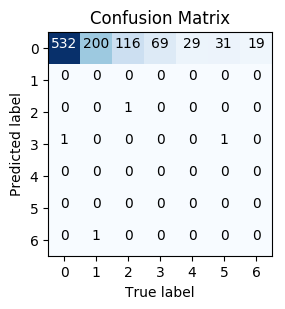

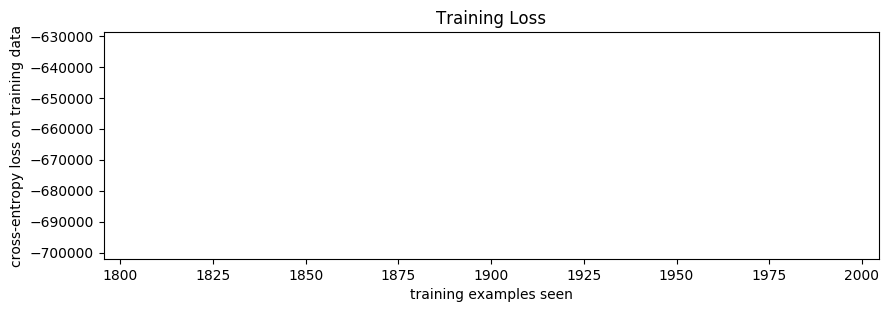

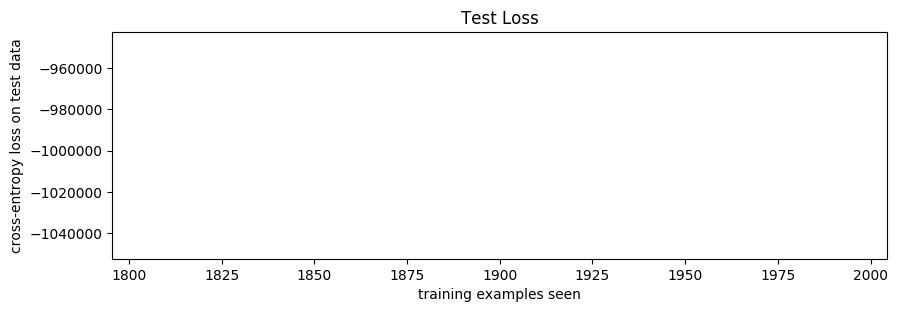

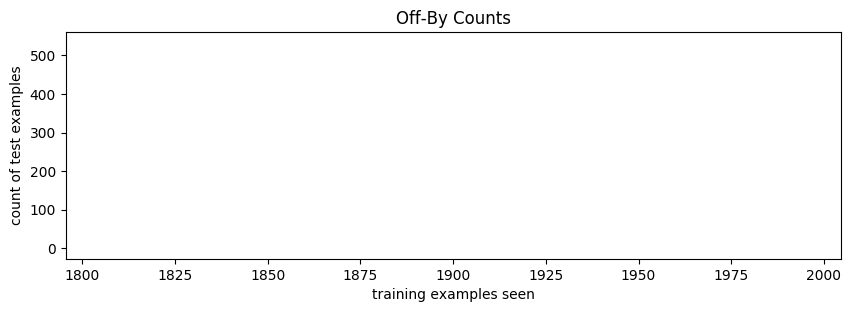

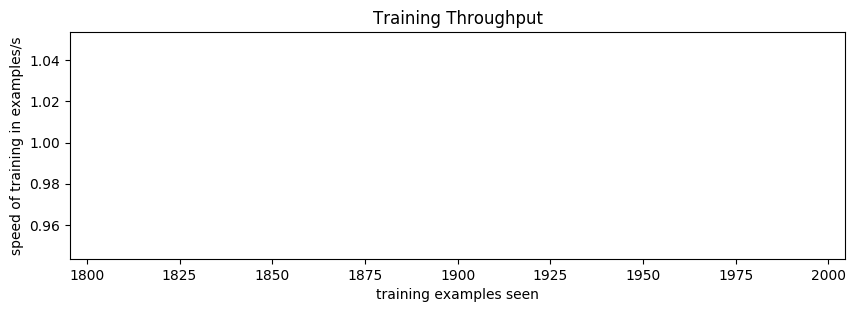

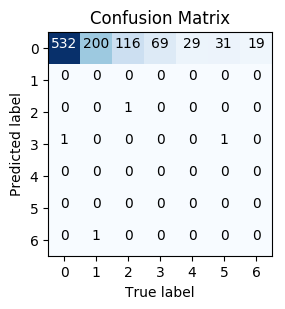

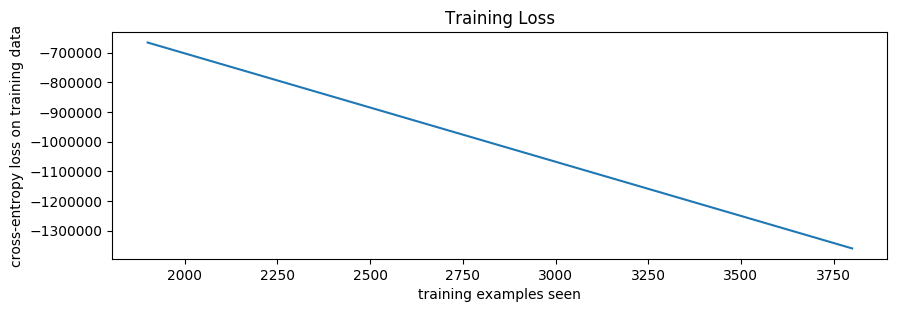

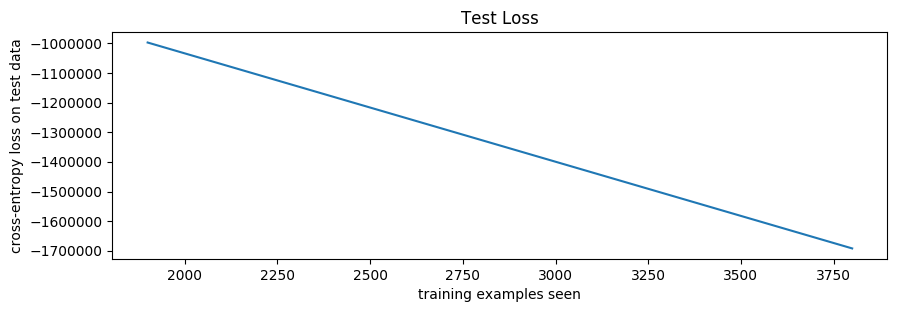

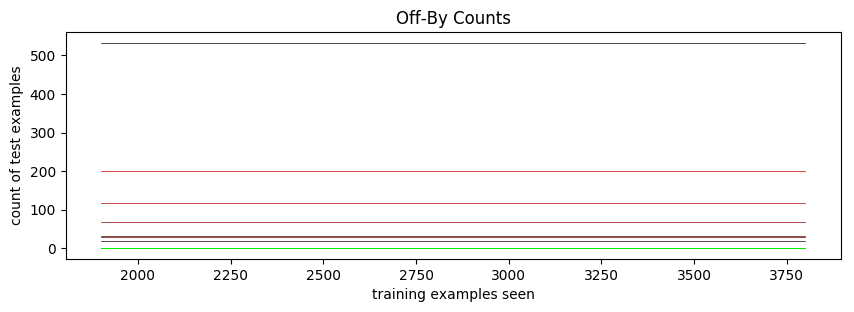

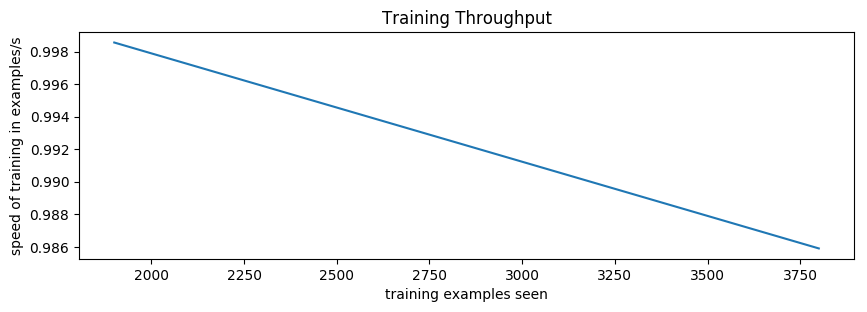

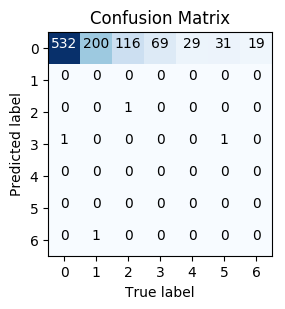

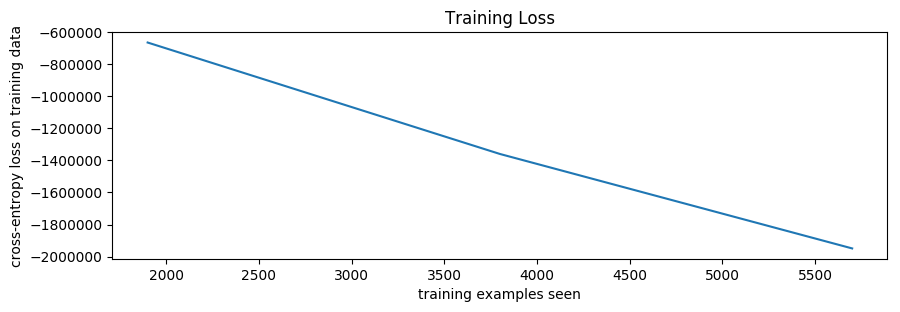

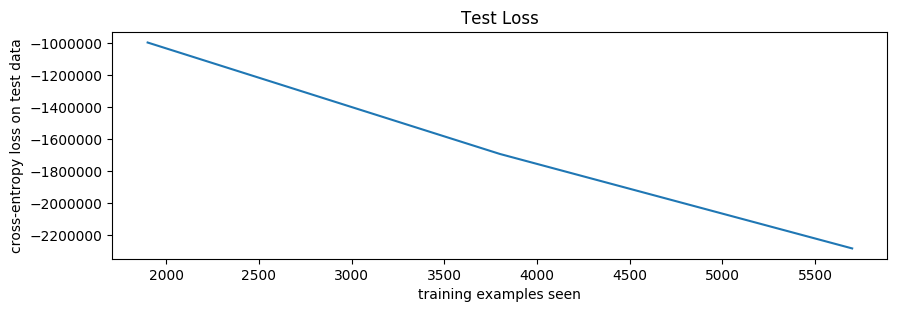

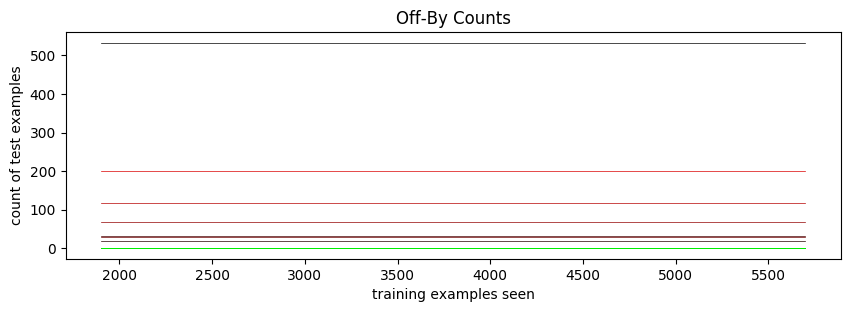

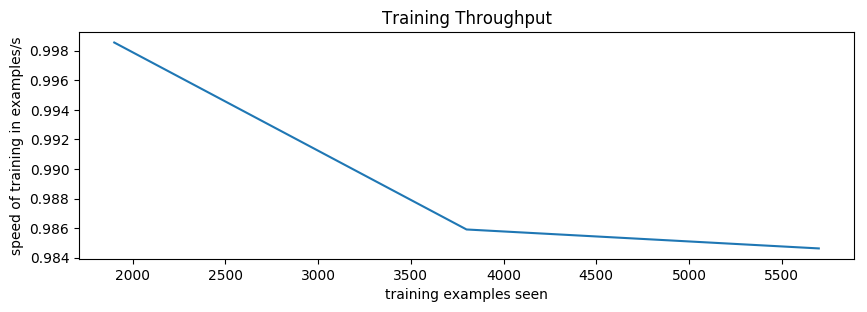

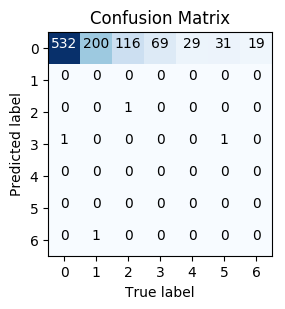

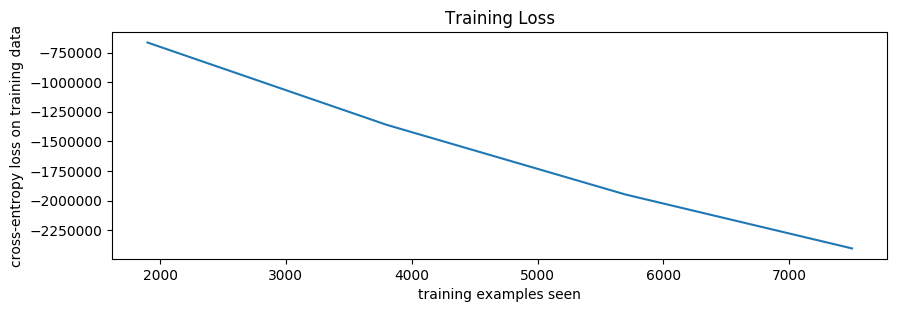

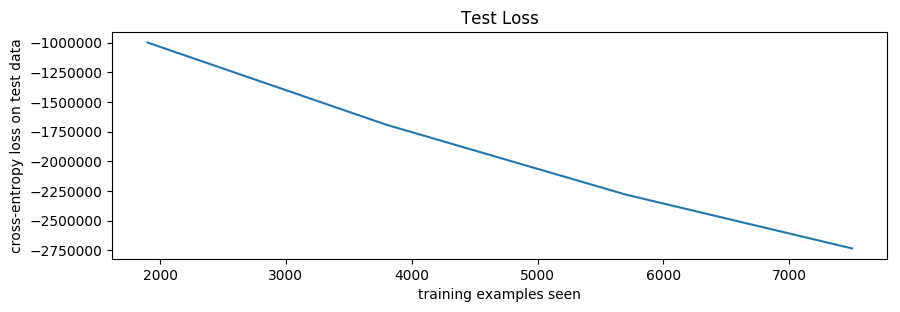

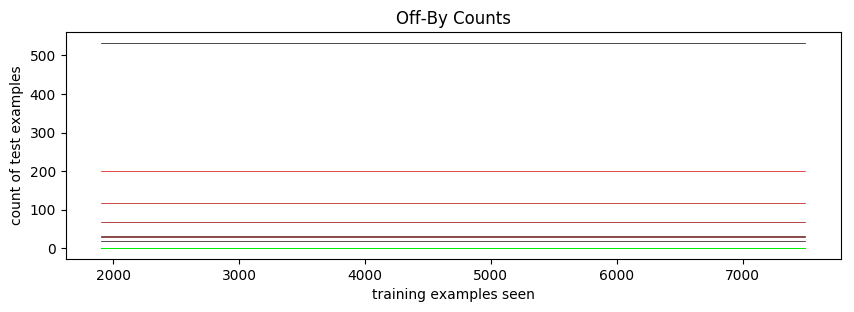

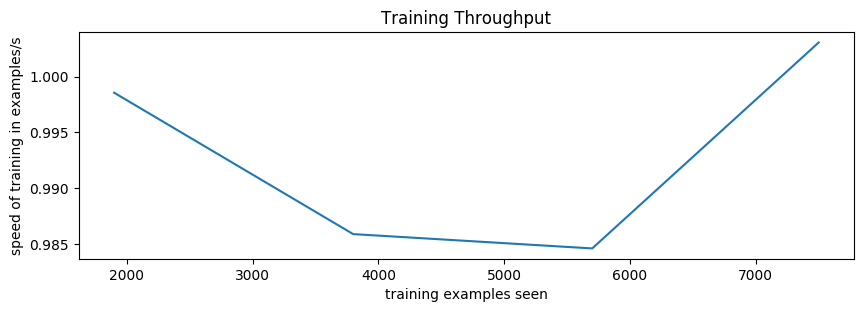

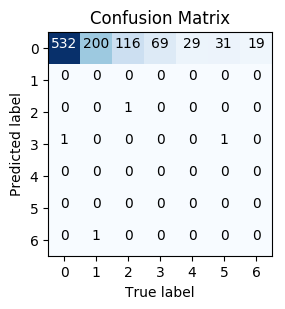

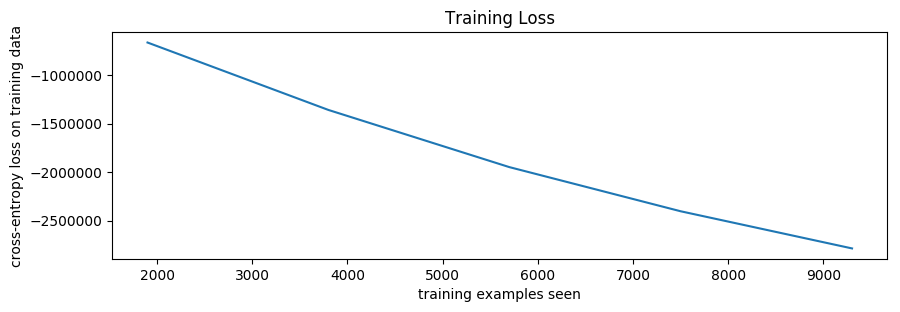

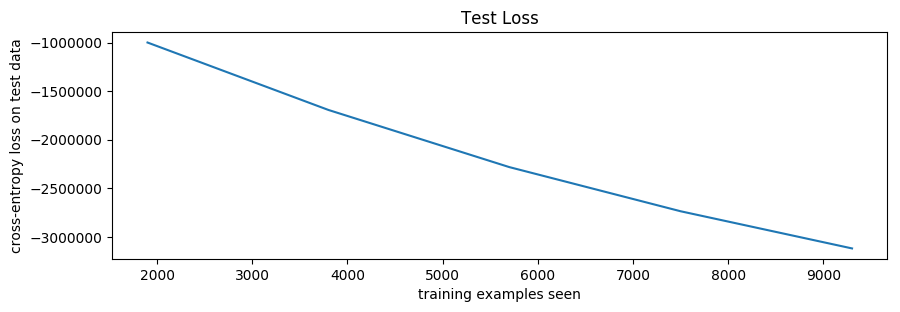

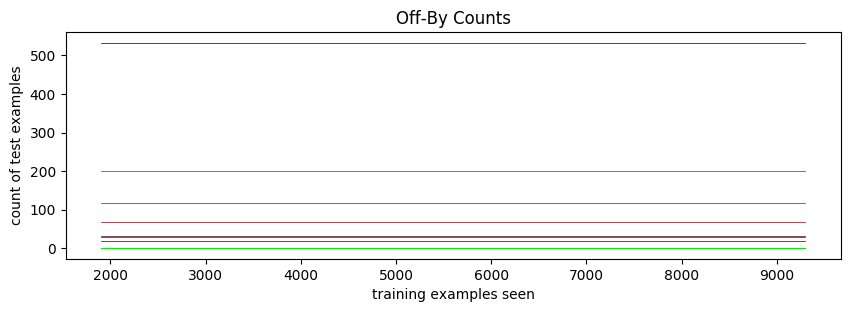

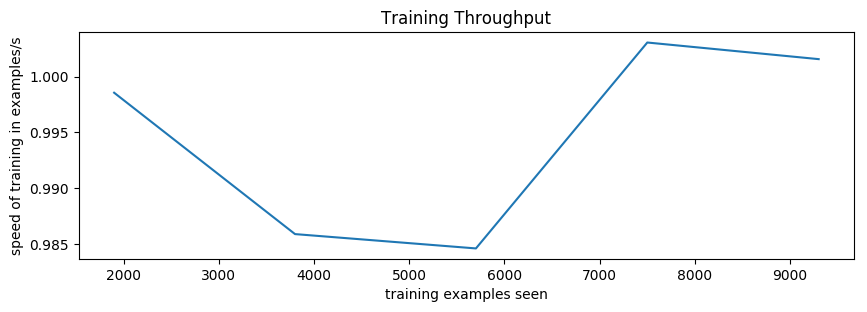

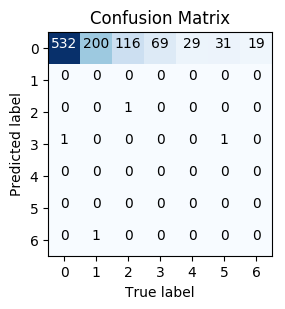

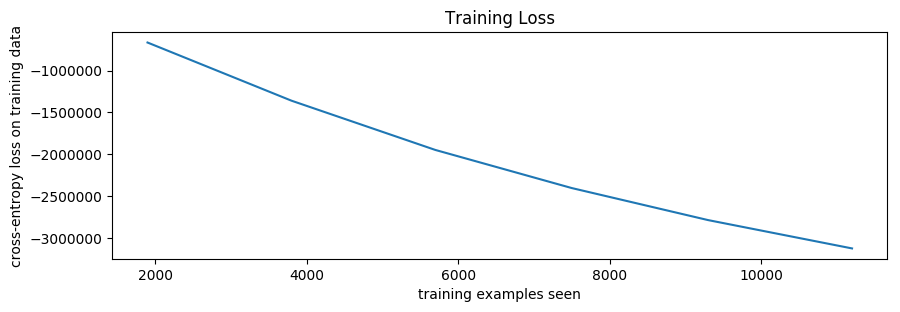

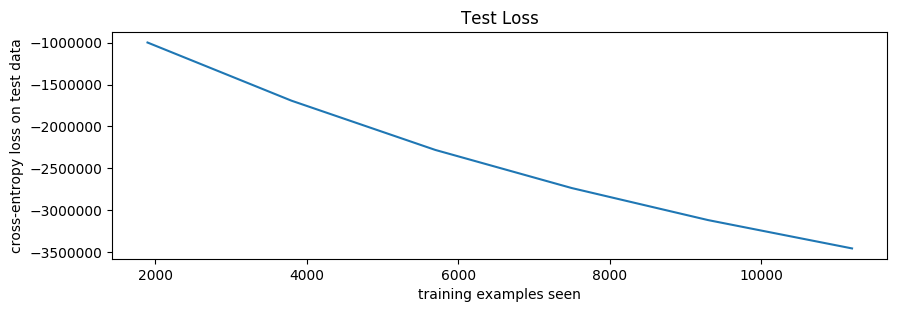

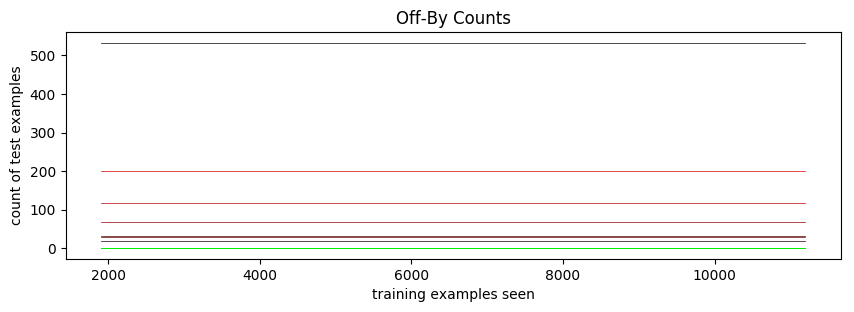

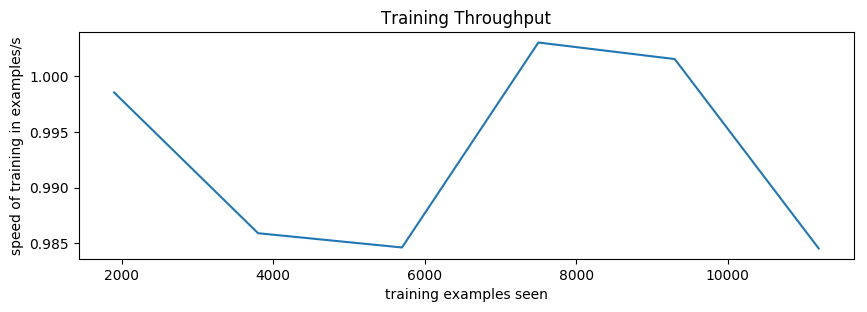

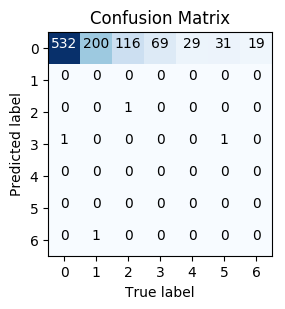

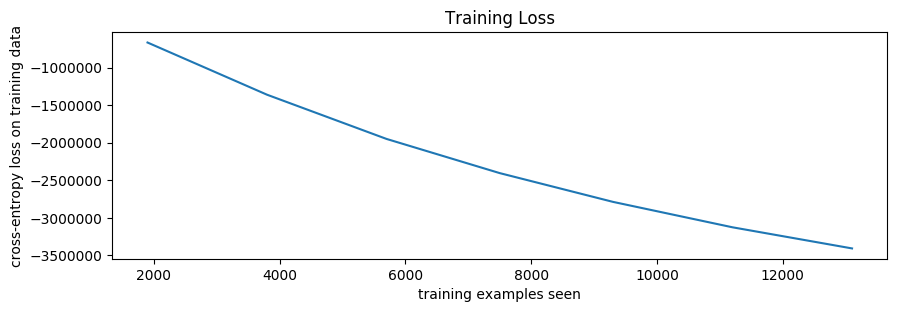

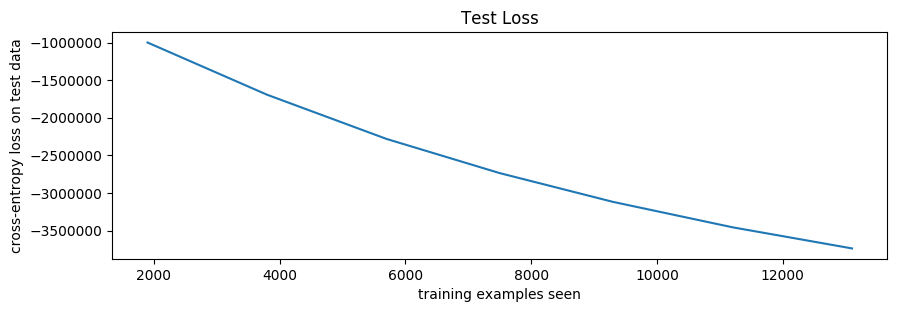

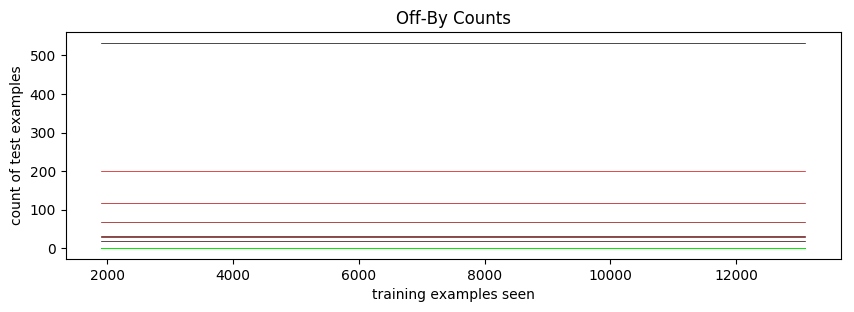

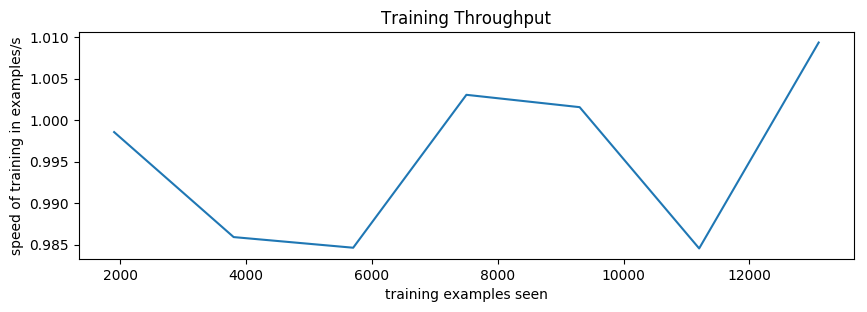

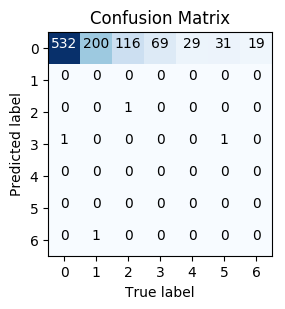

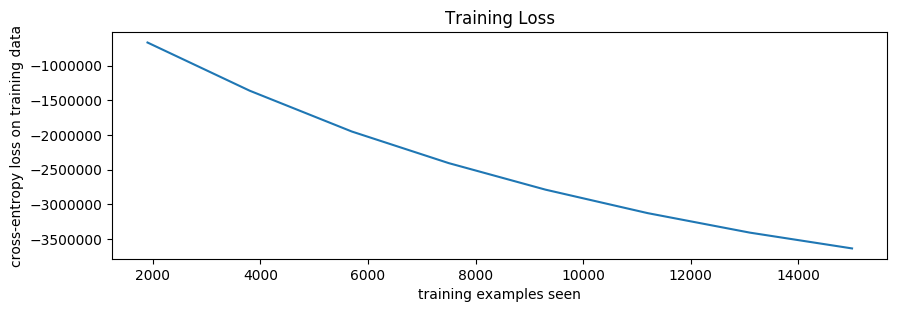

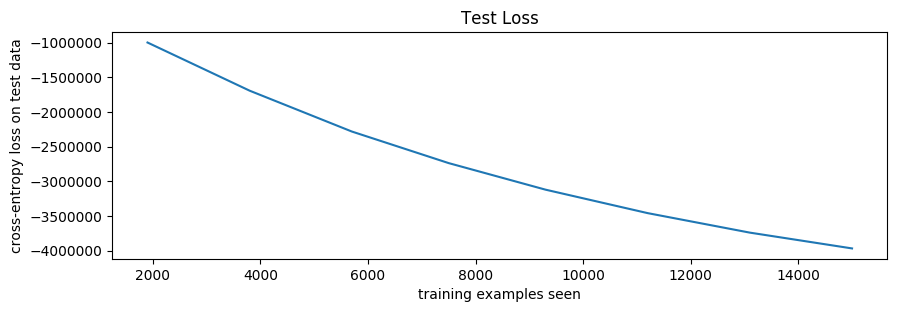

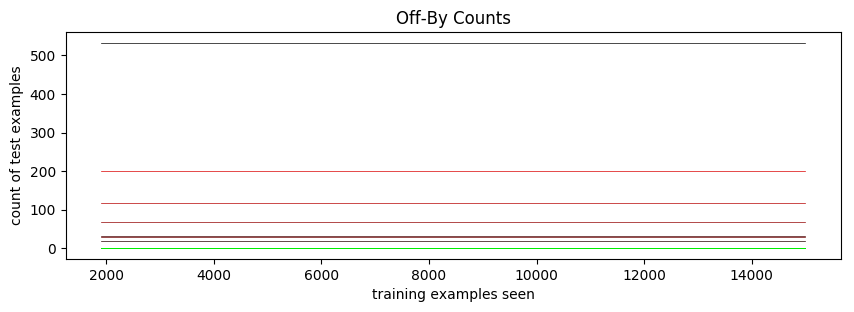

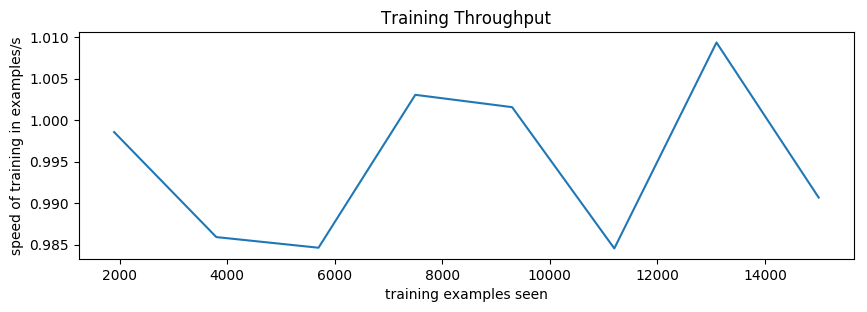

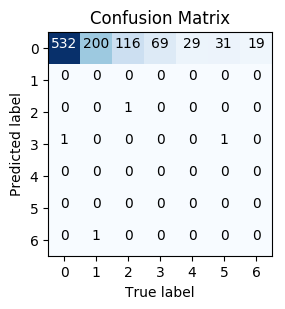

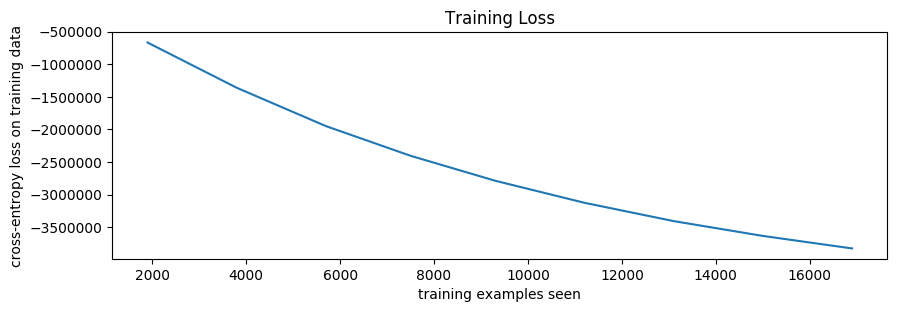

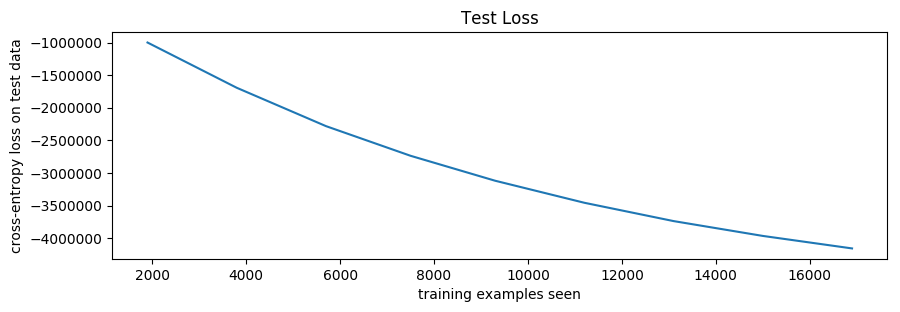

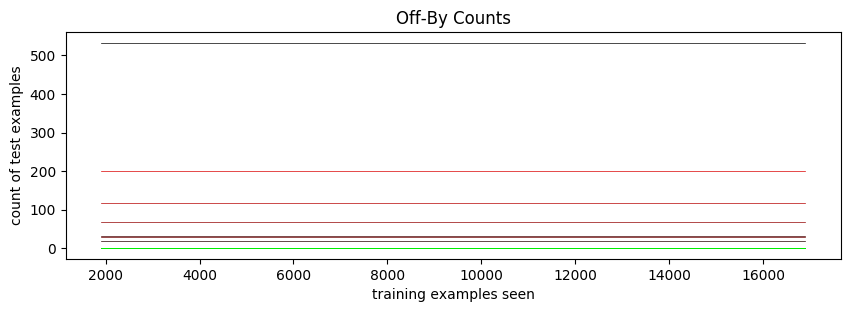

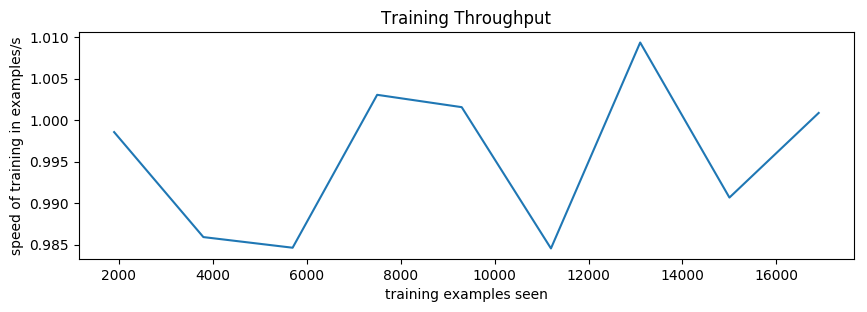

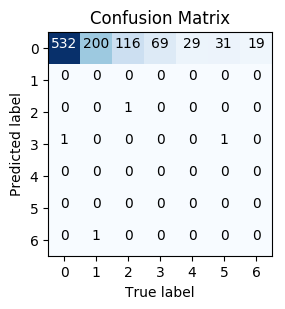

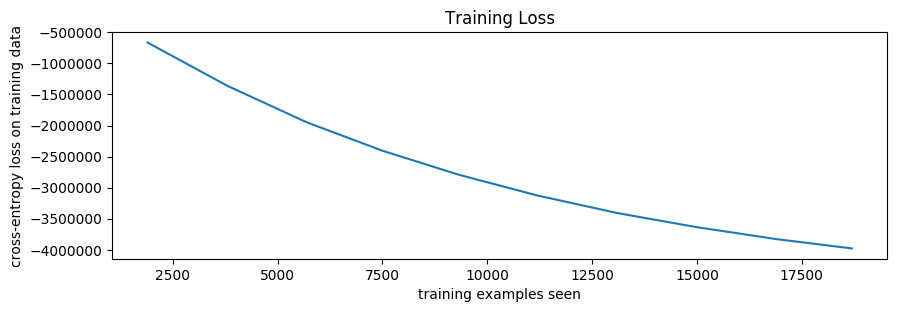

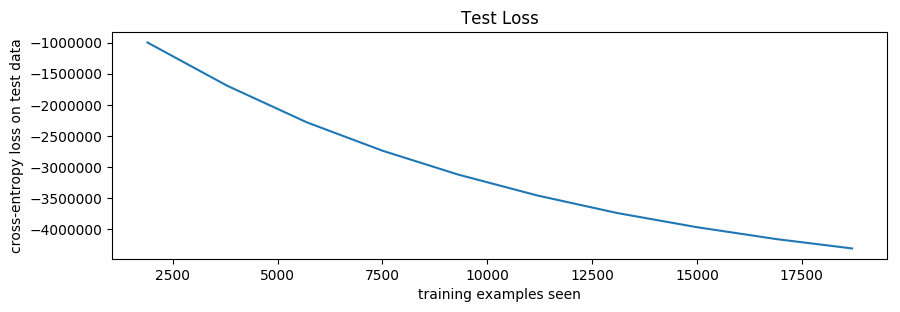

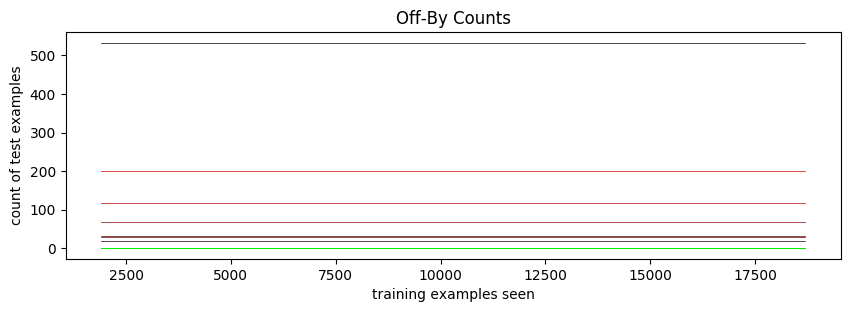

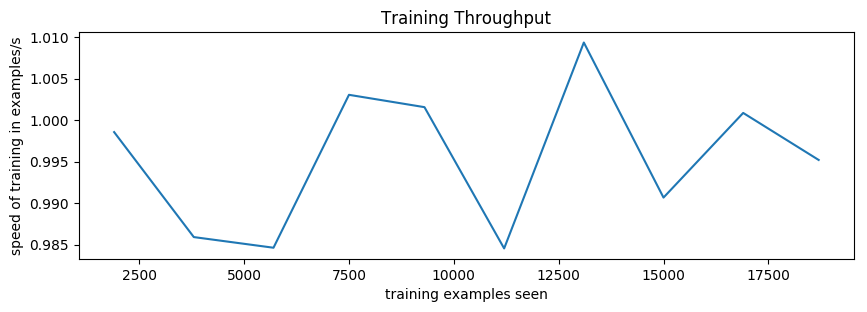

In [15]:
# Alternately train and evaluate the net for 30 minutes.
for _ in range(30//3):
    net.train(train, 3*60)
    net.evaluate(metrics)
    plot_metrics()

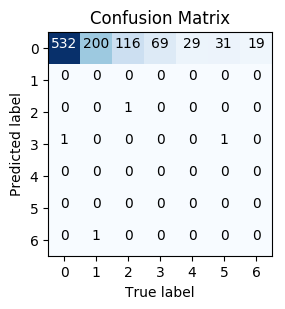

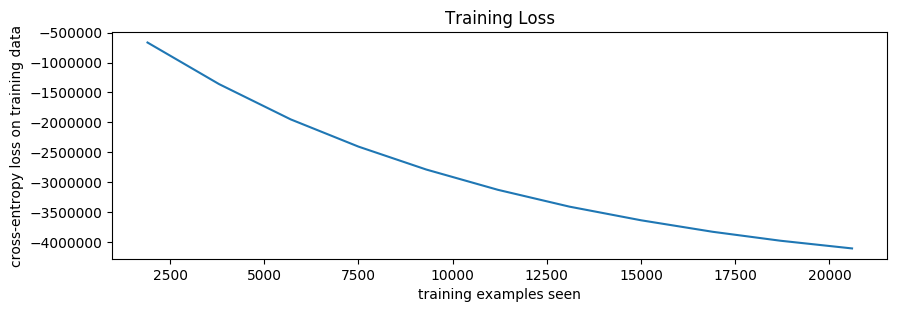

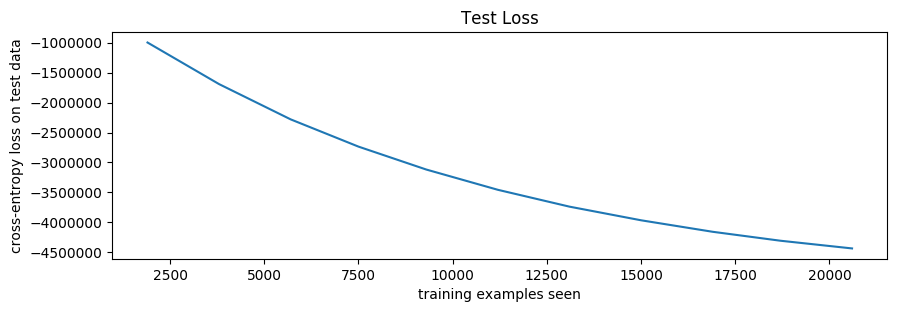

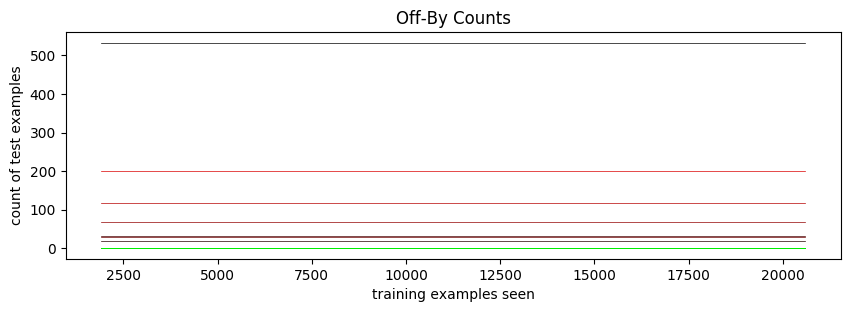

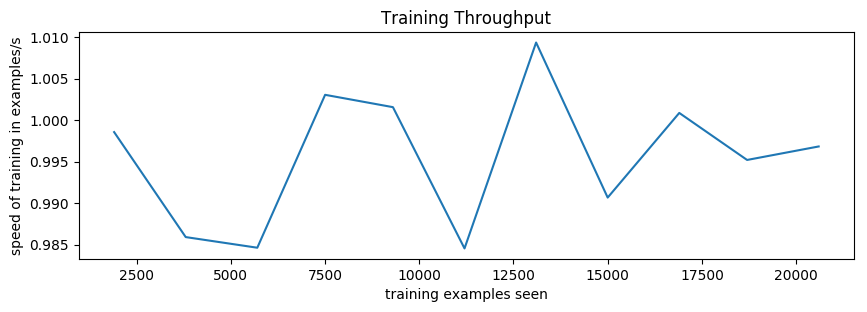

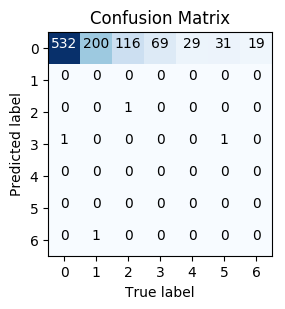

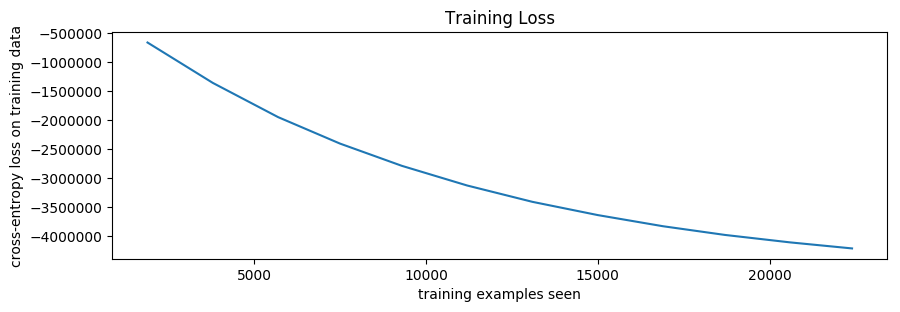

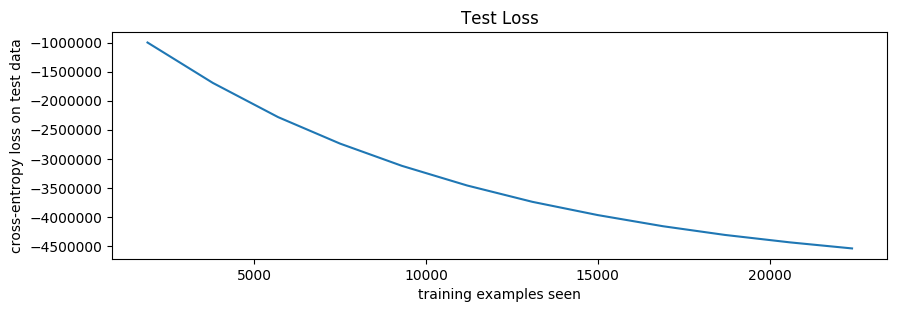

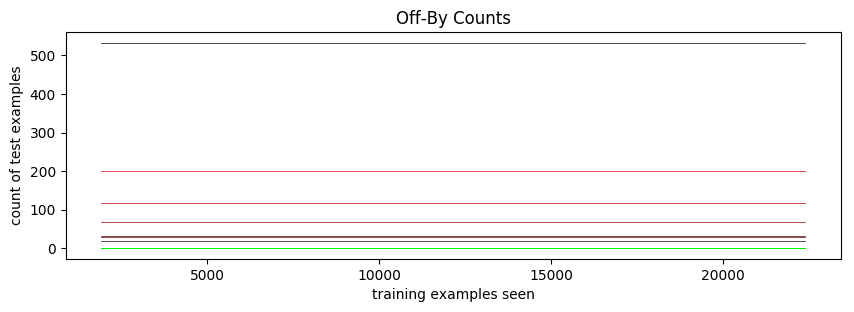

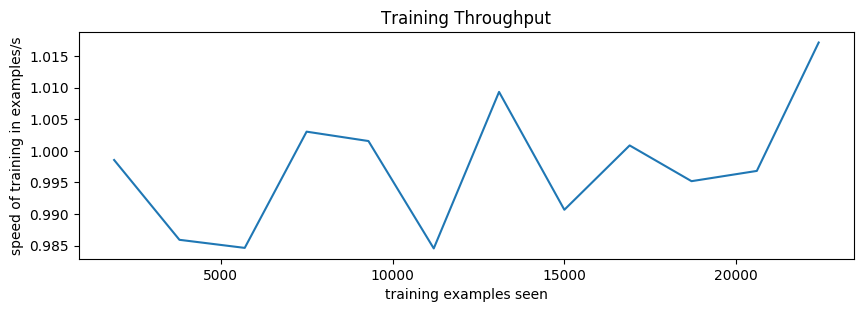

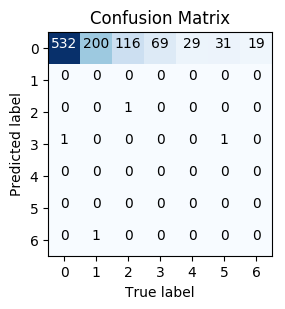

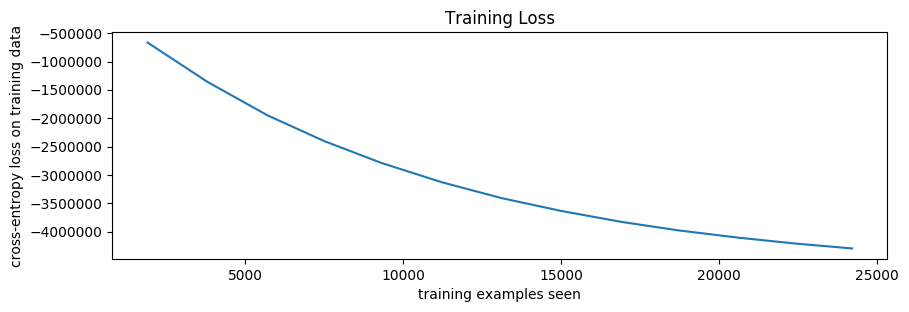

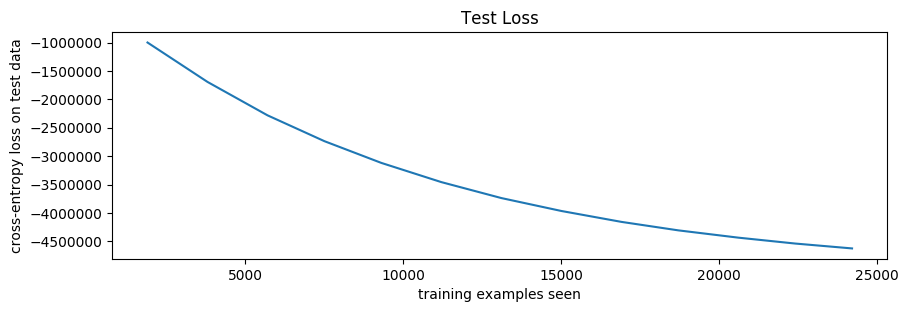

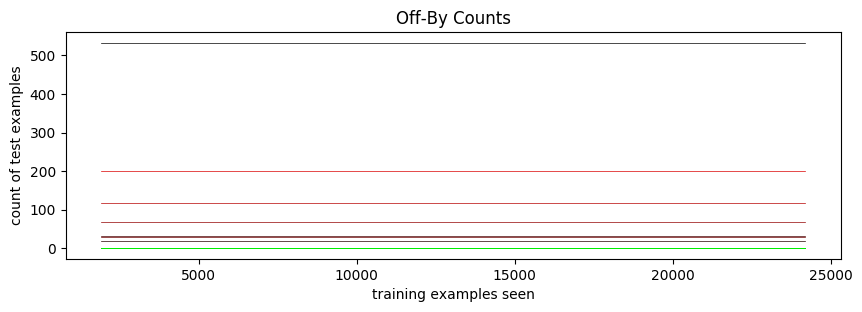

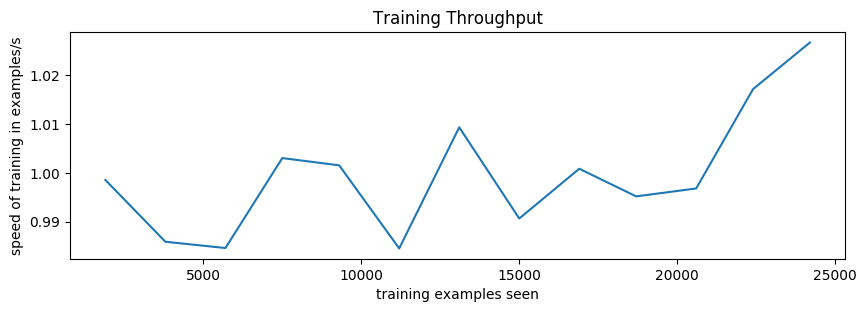

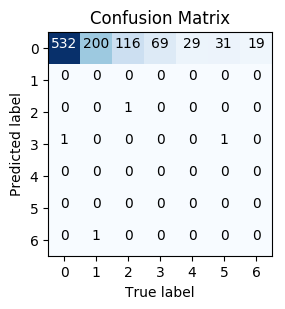

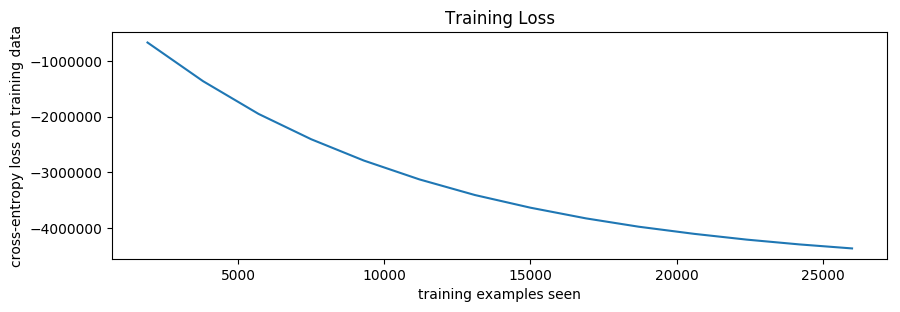

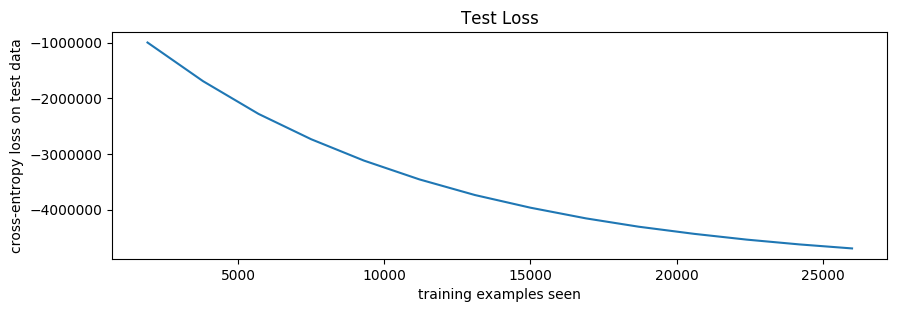

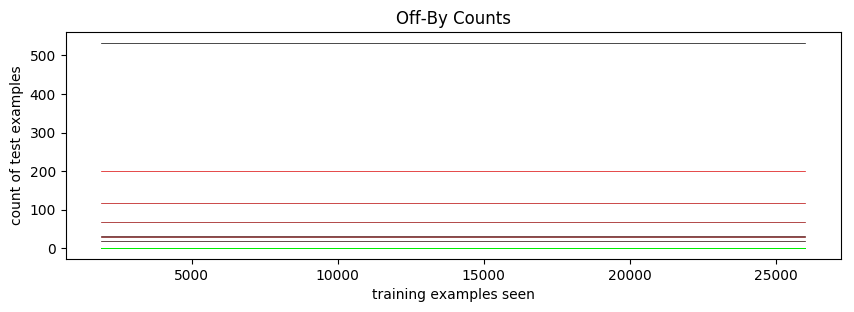

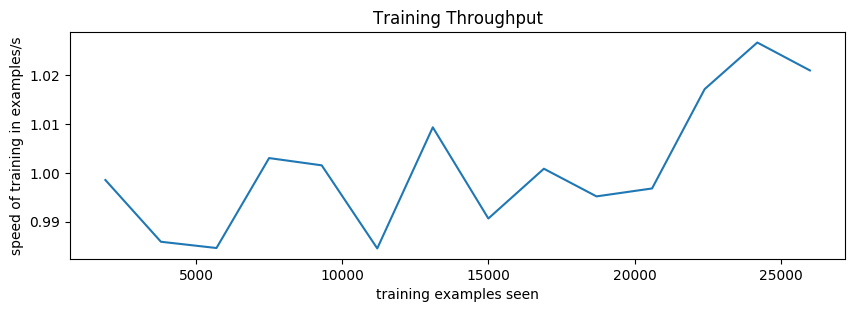

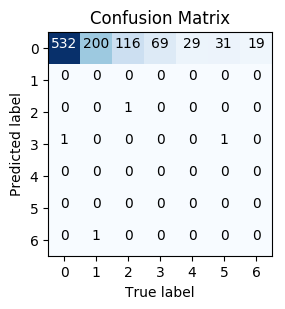

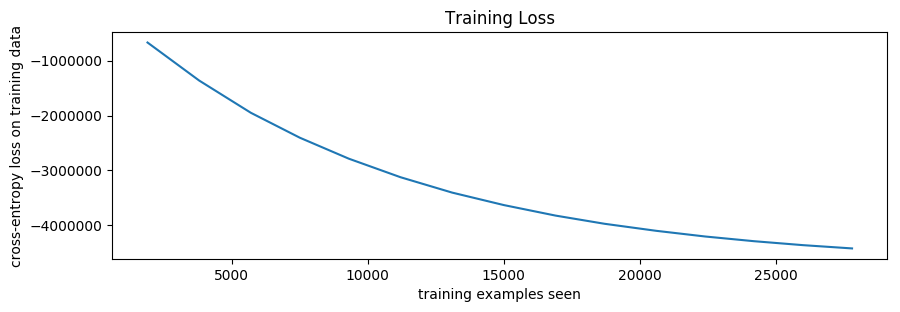

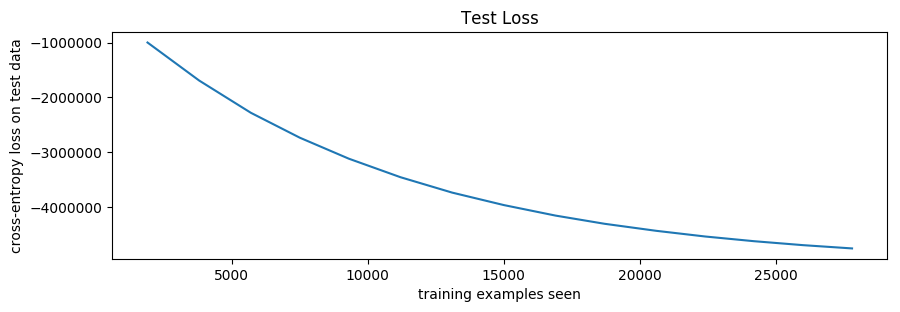

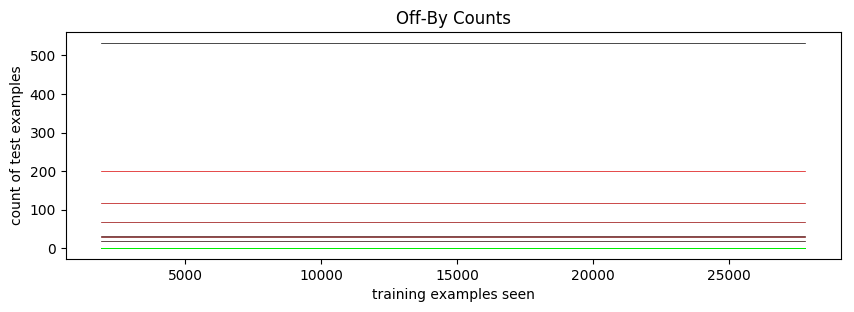

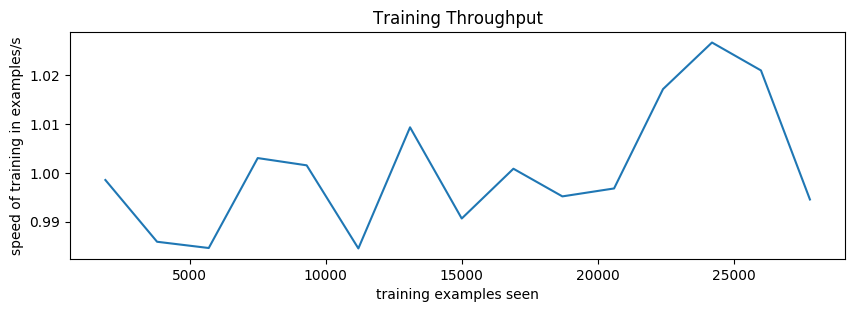

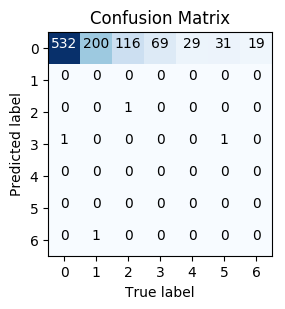

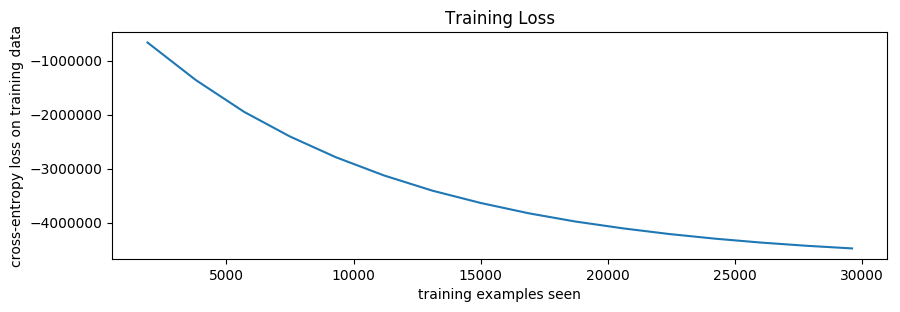

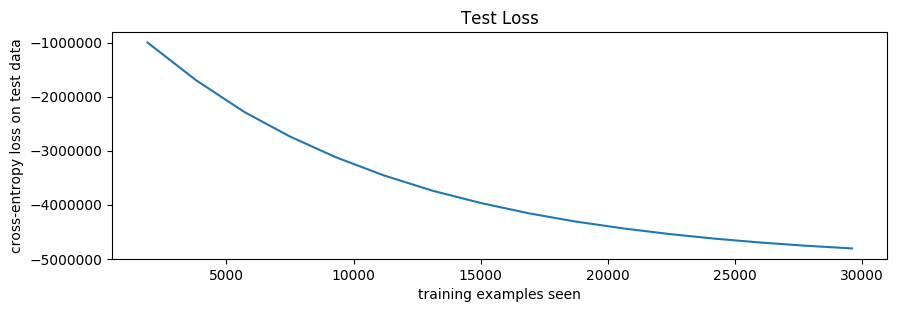

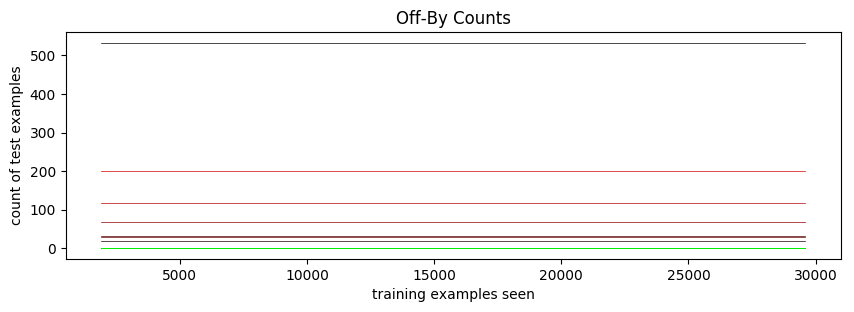

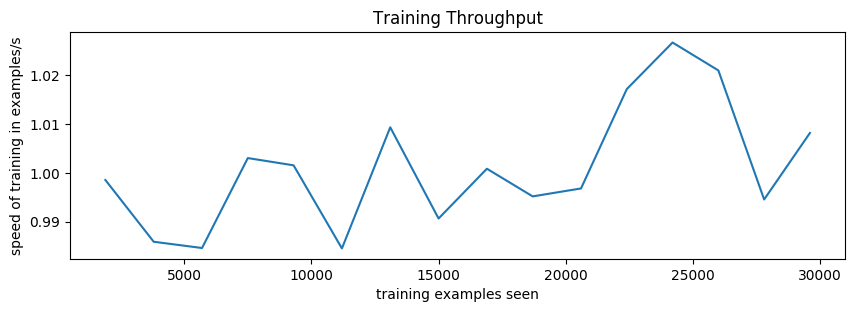

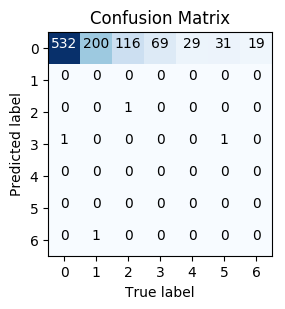

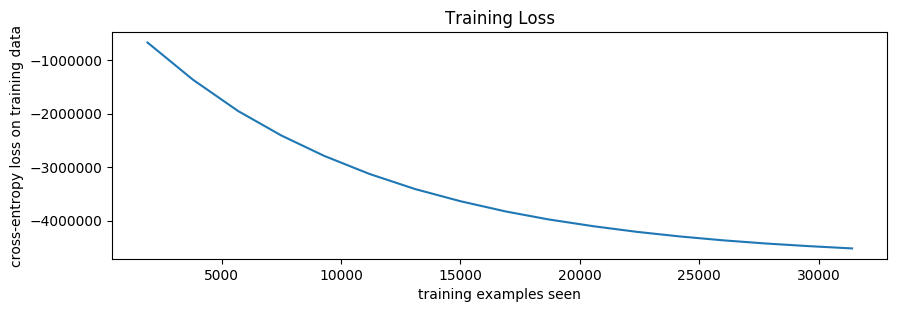

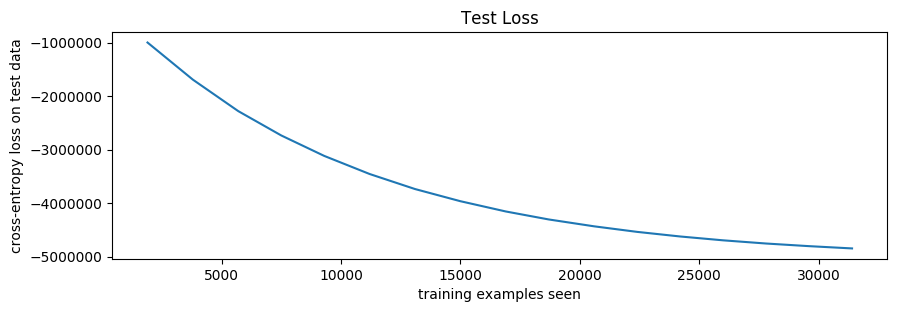

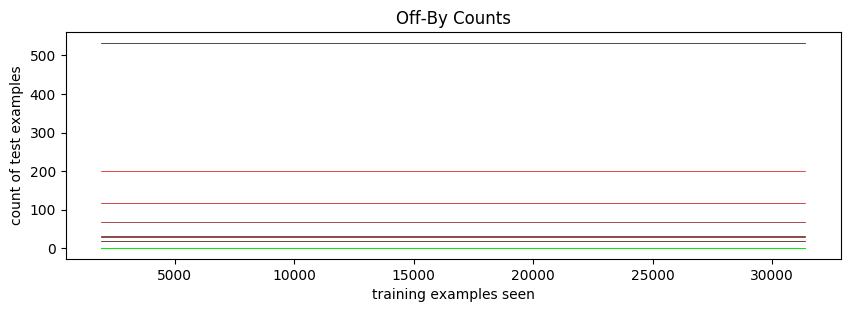

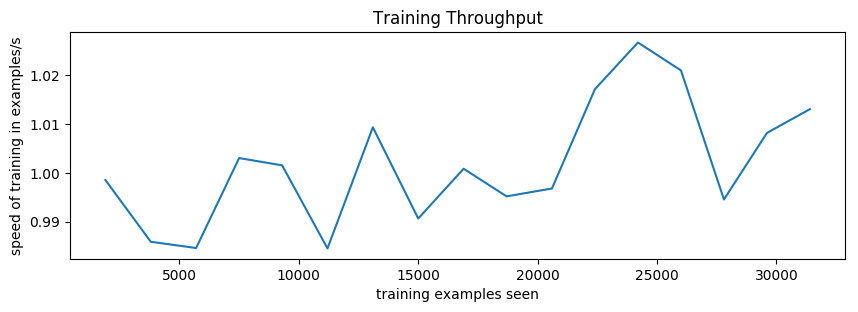

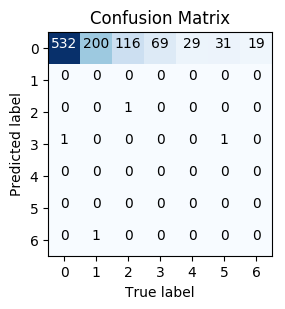

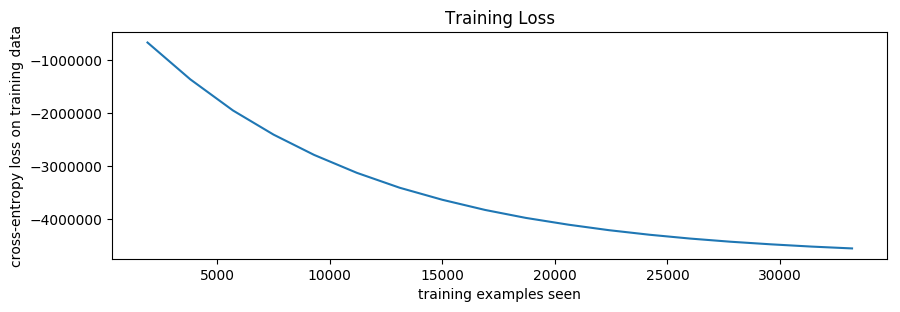

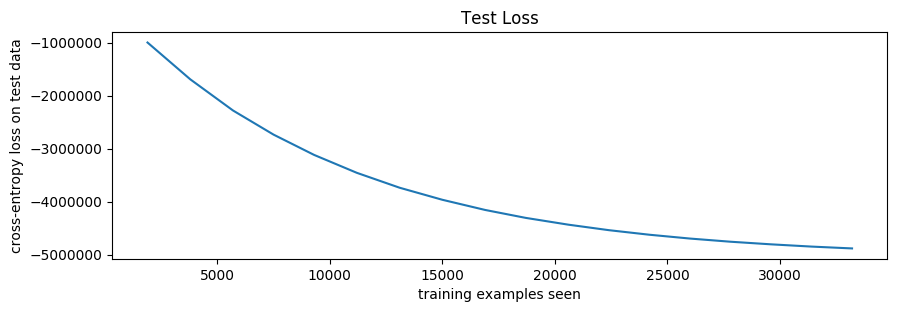

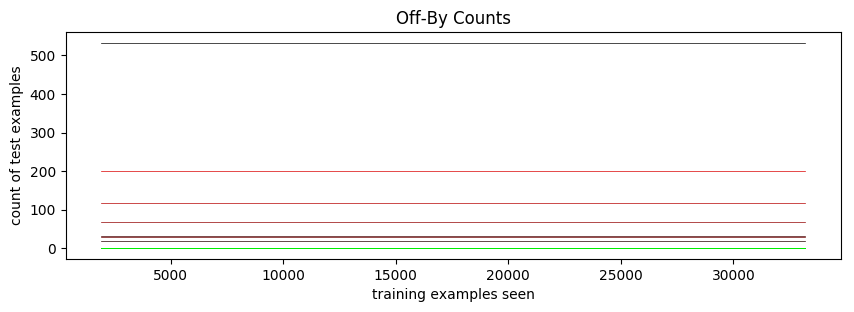

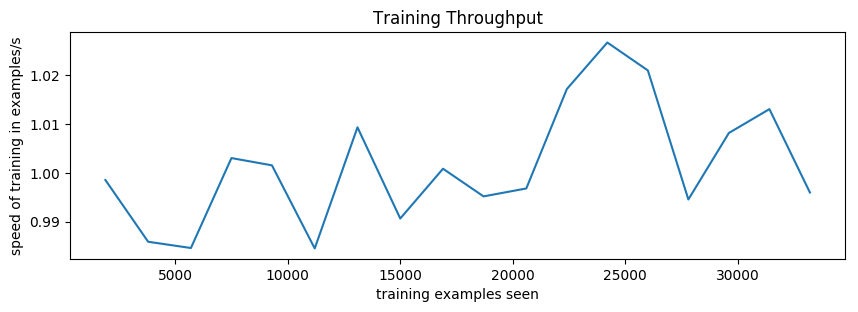

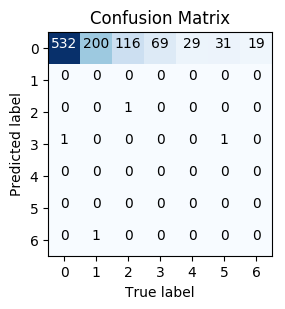

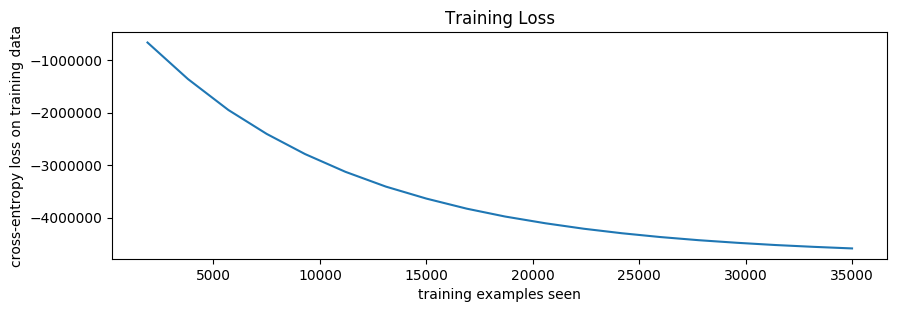

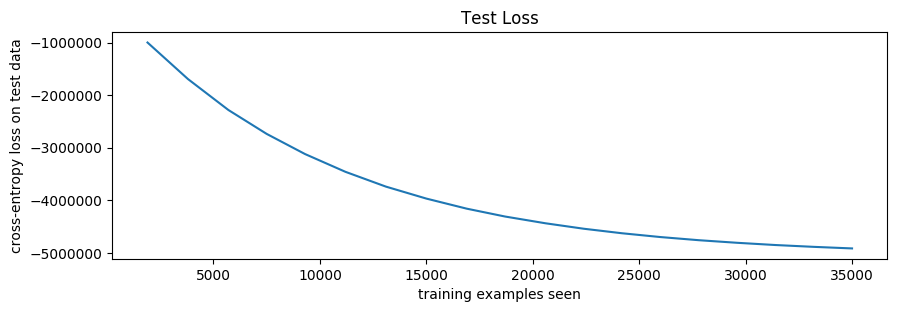

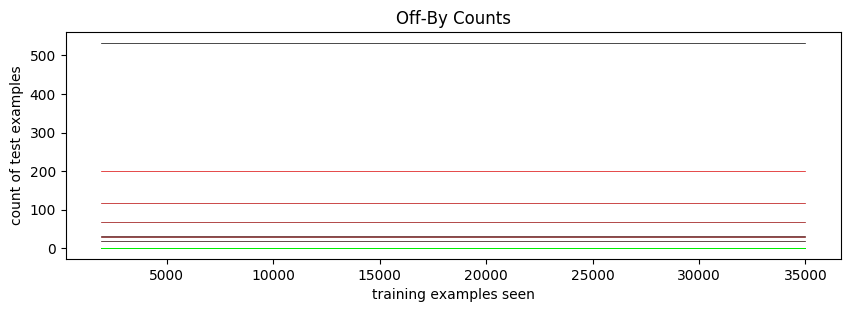

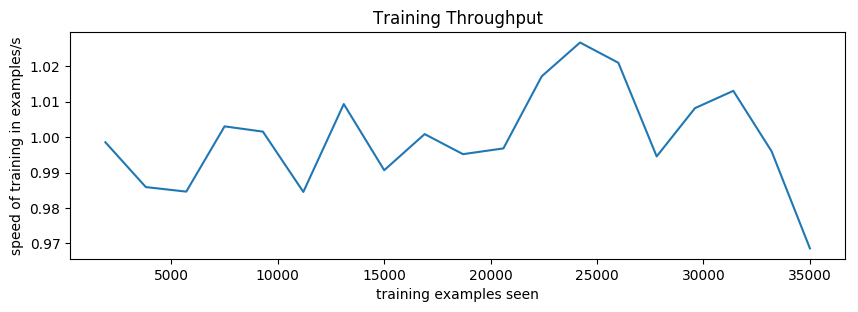

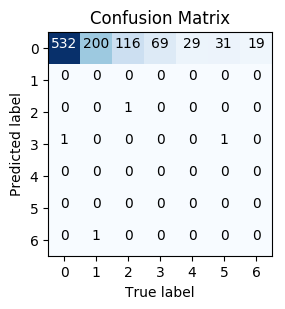

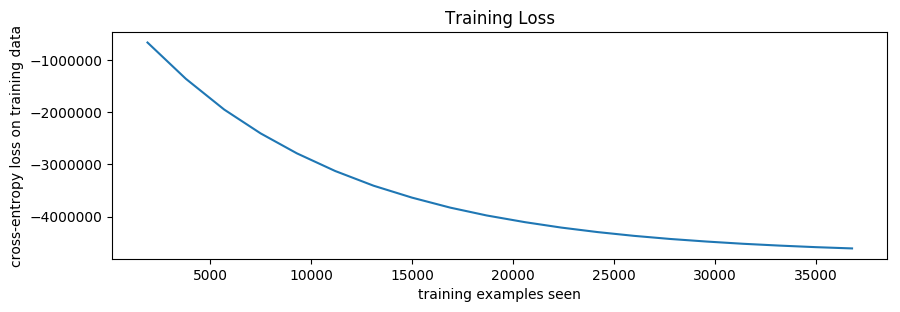

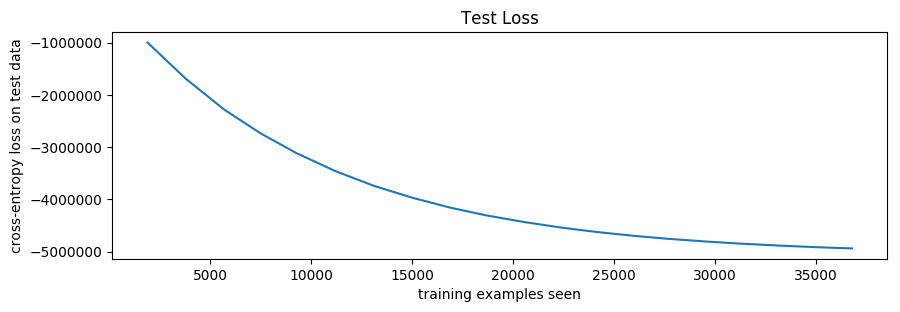

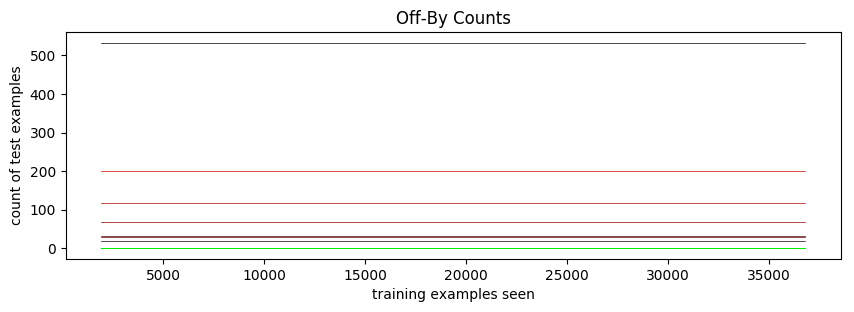

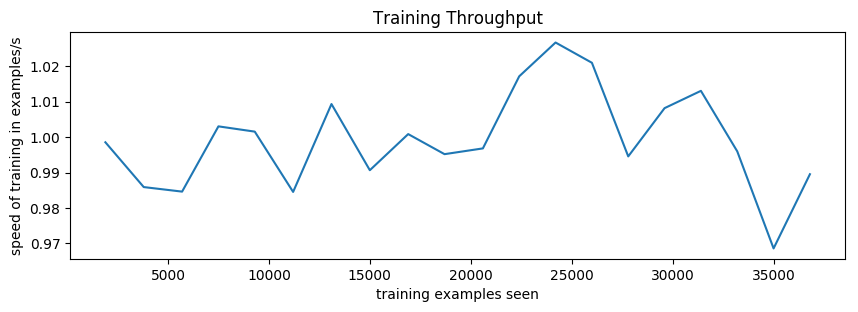

In [16]:
# Alternately train and evaluate the net for 30 minutes.
for _ in range(30//3):
    net.train(train, 3*60)
    net.evaluate(metrics)
    plot_metrics()

In [ ]:
# Close the dataset.
microbia_segments.close()